In [241]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [242]:
# LOAD in fixed simulation parameters
sim_z = fits.open('/Users/kulkarniad/rh_aniso/rhsc3d/ssd_deep/z.fits')[0].data/(1e3) # in km
wl = fits.open('wl.fits')[0].data
NLAMBDA = 472
NZ = 20
NX = 96
NY = 96

#Constants
TRT = 2.0*np.sqrt(2)  # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji note that this is a factor 5 different from NIST
gu = 1 # lande factor of upper level


bx = np.load('/Users/kulkarniad/rh_aniso/rhsc3d/ssd_deep/Bx.npy')
by = np.load('/Users/kulkarniad/rh_aniso/rhsc3d/ssd_deep/By.npy')
bz = np.load('/Users/kulkarniad/rh_aniso/rhsc3d/ssd_deep/Bz.npy')


Bfield = [bz,by,bx]


In [243]:
#find indices of strontium wl
jumps = np.where(np.diff(wl)>10)
ni = jumps[0][0] + 1  # starting wavelength of strontium
nf = jumps[0][1] + 1  # ending wavelength of strontium
lc = (ni + nf)//2  #lince core wavelength

In [244]:
# Create collision depolarization cube.
# Data based on dashed line in Figure 6 of DPA
def load_depol_array():
    data = pd.read_csv('depol.csv') # copy of Figure 6 of aleman and trujillo bueno
    z = data.iloc[:,0]*1e3 # z is in units of km
    delta = data.iloc[:,1] # delta is unitless
    delta_interp = interp1d(z,delta,fill_value= 'extrapolate')
    delta_array = delta_interp(sim_z)
    delta_cube = np.zeros((NZ,NY,NX))
    # Interpolate this function over MURaM z values
    for i in range(NX):
        for j in range(NY):
            delta_cube[:,j,i] = delta_array
    return delta_cube

In [245]:
d2u = load_depol_array()
np.clip(load_depol_array(),0,0, out=d2u);

In [246]:
# Z needs to be rigourously defined here

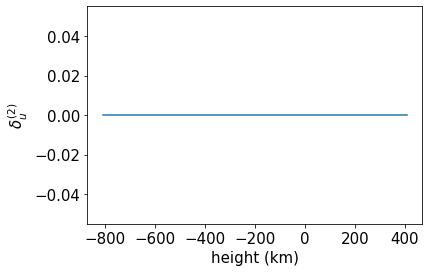

In [247]:
plt.plot(sim_z[:30],d2u[:30,0,0])
plt.xlabel('height (km)',fontsize = 15)
plt.ylabel('$\delta_u^{(2)}$',fontsize = 15)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.savefig('/Users/kulkarniad/Desktop/d2u.pdf')

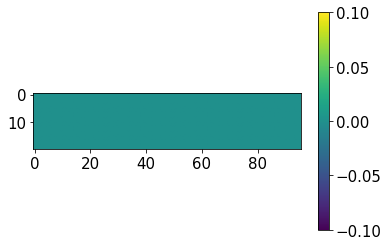

In [248]:
plt.imshow(d2u[:,:,32])
plt.colorbar()

In [249]:
class Opacity:
    def __init__(self,dir_loc):        
        data = fits.open(dir_loc+'opac_l.fits')
        self.opac_l = data[0].data
        data = fits.open(dir_loc+'opac_c.fits')
        self.opac_c = data[0].data

        data = fits.open(dir_loc+'emis_l.fits')
        self.emis_l = data[0].data
        data = fits.open(dir_loc+'emis_c.fits')
        self.emis_c = data[0].data
            

In [250]:
def epsilon(dir_loc):
    cij = np.loadtxt(dir_loc+'Cij8.txt').reshape(NZ,NY,NX)
    return cij/(cij+Aij)
    

$\varepsilon$ ranges from $\sim 1$ down low in the atmosphere to less than $0.01$ near the top of the atmosphere

In [251]:
class Sphr_tensors:
    def __init__(self,dir_loc):
        # spherical J tensors
        self.j00 = np.loadtxt(dir_loc+'J00.txt').reshape(NZ,NY,NX)
        self.j20 = np.loadtxt(dir_loc+'J20.txt').reshape(NZ,NY,NX)
        self.imj21 = np.loadtxt(dir_loc+'imJ21.txt').reshape(NZ,NY,NX)
        self.imj22 = np.loadtxt(dir_loc+'imJ22.txt').reshape(NZ,NY,NX)
        self.rej21 = np.loadtxt(dir_loc+'reJ21.txt').reshape(NZ,NY,NX)
        self.rej22 = np.loadtxt(dir_loc+'reJ22.txt').reshape(NZ,NY,NX)

In [253]:
class Source_function:
    def __init__(self,dir_loc):
        
        self.st = Sphr_tensors(dir_loc)# Load spherical tensors    
        self.eps = epsilon(dir_loc) # Load epsilon paramter  
        
        # opacity parameters
        self.opcty = Opacity(dir_loc)        
        self.r = self.opcty.opac_l / (self.opcty.opac_l  + self.opcty.opac_c )
        self.source_l = self.opcty.emis_l/self.opcty.opac_l
        self.source_c = self.opcty.emis_c/self.opcty.opac_c
        
        # create optical depth array
        total_opac = self.opcty.opac_l  + self.opcty.opac_c
        self.tau_cube = np.zeros((NLAMBDA,NZ,NY,NX))
        for l in range(NLAMBDA):
            for i in range(NX):
                for j in range(NY):
                    self.tau_cube[l,:,j,i] = cumtrapz(total_opac[l,:,j,i], x=sim_z*1e3,initial=-1e-5) * (-1.0)
            
    
        self.s00 = self.source_l # define this to be the line source function
        
    def computeS(self):
        # eq 5 of del pino aleman (DPA)
        C1 = (1-self.eps)/(1+d2u*(1-self.eps))
        
        J = C1*[self.st.j20, self.st.rej21, -1.*self.st.imj21,self.st.rej22, -1.*self.st.imj22]
        
        self.s20 = np.zeros((NZ,NY,NX))
        self.res21 = np.zeros((NZ,NY,NX))
        self.ims21 = np.zeros((NZ,NY,NX))
        self.res22 = np.zeros((NZ,NY,NX))
        self.ims22 = np.zeros((NZ,NY,NX))

        #loop over cells
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    Bz,By,Bx = Bfield[0][k,j,i],Bfield[1][k,j,i],Bfield[2][k,j,i]
                    B_mag = np.sqrt(Bz**2 + By**2 + Bz**2)
                    gamma = 8.79e6 * gu * B_mag/Aij


                    tB = np.arccos(Bz/B_mag) #thetaB
                    cB = np.arctan2(By,Bx) #chiB

                    matM = np.array([[0,M12(tB,cB),M13(tB,cB),0,0],
                                        [M21(tB,cB),0,M23(tB,cB),M24(tB,cB),M25(tB,cB)],
                                        [M31(tB,cB),M32(tB,cB),0,M34(tB,cB),M35(tB,cB)],
                                        [0,M42(tB,cB),M43(tB,cB),0,M45(tB,cB)],
                                        [0,M52(tB,cB),M53(tB,cB),M54(tB,cB),0]
                                        ])

                    matM *= C1[k,j,i]*gamma
                    
                    # Now solve linear system
                    #x = J + Mx
                    #(I - M)x = J
                    svec = np.linalg.solve(np.eye(5) - matM, J[:,k,j,i])
                    self.s20[k,j,i], self.res21[k,j,i], self.ims21[k,j,i], self.res22[k,j,i], self.ims22[k,j,i] = svec
                
        
    # Line source functions 
    #(eq 6 of DPA)
    def si_line(self,mu,azi):
        c1 = 1/TRT*(3*mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1-mu**2)        

        out = self.s00 + c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out+= c3*(self.res22*np.cos(2*azi) - self.ims22*np.sin(2*azi)) 

        return out

    #(eq 7 of DPA)
    def sq_line(self,mu,azi):
        c1 = 3/TRT*(mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1+mu**2)

        out = c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out-= c3*(self.res22*np.cos(2*azi)-self.ims22*np.sin(2*azi))
        
        return out

    #(eq 8 of DPA)
    def su_line(self,mu,azi):
        c1 = np.sqrt(1-mu**2)
        
        out = c1*(self.res21*np.sin(azi) + self.ims21*np.cos(azi)) 
        out += mu*(self.res22*np.sin(2*azi) + self.ims22*np.cos(2*azi))

        out *= np.sqrt(3.0)
        return out
    
# Now Calculate source functions of I, Q U:         
    def source_i(self,mu,azi):
        self.computeS()
        return self.r*self.si_line(mu,azi) + (1-self.r)*self.source_c

    def source_q(self,mu,azi):
        self.computeS()
        return self.r*self.sq_line(mu,azi)  # check that some wierd broadcasting is not going on here!

    def source_u(self,mu,azi):
        self.computeS()
        return self.r*self.su_line(mu,azi) 

Source funcs are loaded and ready to rumble!

###  Now apply formal solution to derived source functions

In [254]:
# FORMAL solver for vertical rays

def sc_formal_solver(I_upwind,delta,S_upwind,S_local):
 
    expd = np.exp(-delta)
    w_local = 1.0 - 1.0/delta * (1.0 - expd)
    w_upwind = -expd + 1.0/delta * (1.0 - expd)
 
    I_local = I_upwind * expd + w_local * S_local + w_upwind * S_upwind
 
    return I_local


def formal_3d(S,tau_cube):
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Source function must be a 4D cube'
    assert S.shape == (NLAMBDA, NZ, NY, NX), 'Tau must be a 4D cube'
    
    I_cube = np.zeros((NLAMBDA,NZ,NY,NX))
    I_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

    for l in np.arange(ni,nf):
        for j in range(NY):
            for i in range(NX):
                for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                    dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                    I_cube[l,d,j,i] = sc_formal_solver(I_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])
    
    return I_cube # return emergent intensity at all depths


In [255]:
def M12(thta,chi):
    return np.sqrt(6) * np.sin(thta) * np.sin(chi)

def M13(thta,chi):
    return np.sqrt(6) * np.sin(thta) * np.cos(chi)

def M21(thta,chi):
    return -np.sqrt(3/2) * np.sin(thta) * np.sin(chi)



def M23(thta,chi):
    return np.cos(thta)

def M32(thta,chi):
    return -np.cos(thta)


def M24(thta,chi):
    return np.sin(thta) * np.sin(chi)

def M35(thta,chi):
    return M24(thta,chi)

def M42(thta,chi):
    return -M24(thta,chi)

def M53(thta,chi):
    return -M24(thta,chi)



def M25(thta,chi):
    return np.sin(thta) * np.cos(chi)

def M43(thta,chi):
    return M25(thta,chi)

def M34(thta,chi):
    return -M25(thta,chi)

def M52(thta,chi):
    return -M25(thta,chi)

def M31(thta,chi):
    return -np.sqrt(3/2) *np.sin(thta) * np.cos(chi)


def M45(thta,chi):
    return 2*np.cos(thta)

def M54(thta,chi):
    return -M45(thta,chi)

# Synthesize muram pol

In [256]:
import time

In [257]:
start = time.time()
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/ssd_deep/')

i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('hanle_deep_I.fits',overwrite=True)

i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('hanle_deep_Q.fits',overwrite=True)

i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('hanle_deep_U.fits',overwrite=True)

print(time.time() - start)

311.4679329395294


In [262]:
hanle_deep_I = fits.open('hanle_deep_I.fits')[0].data
hanle_deep_Q = fits.open('hanle_deep_Q.fits')[0].data
hanle_deep_U = fits.open('hanle_deep_U.fits')[0].data

deep_I = fits.open('deep_I.fits')[0].data
deep_Q = fits.open('deep_Q.fits')[0].data
deep_U = fits.open('deep_U.fits')[0].data

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(deep_Q[lc,0]/deep_I[lc,0],cmap='bwr')
plt.clim(-0.01,0.01)
plt.title('No hanle effect')
plt.colorbar()

plt.subplot(122)
plt.imshow(hanle_deep_Q[lc,0]/hanle_deep_I[lc,0],cmap='bwr')
plt.clim(-0.01,0.01)
plt.colorbar()
plt.title('hanle effect')
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


In [91]:
deep_I = fits.open('deep_I.fits')[0].data
deep_Q = fits.open('deep_Q.fits')[0].data
deep_U = fits.open('deep_U.fits')[0].data

nohanle_deep_I = fits.open('nohanle_deep_I.fits')[0].data
nohanle_deep_Q = fits.open('nohanle_deep_Q.fits')[0].data
nohanle_deep_U = fits.open('nohanle_deep_U.fits')[0].data

shallow_I = fits.open('shallow_I.fits')[0].data
shallow_Q = fits.open('shallow_Q.fits')[0].data
shallow_U = fits.open('shallow_U.fits')[0].data

nohanle_shallow_I = fits.open('nohanle_shallow_I.fits')[0].data
nohanle_shallow_Q = fits.open('nohanle_shallow_Q.fits')[0].data
nohanle_shallow_U = fits.open('nohanle_shallow_U.fits')[0].data




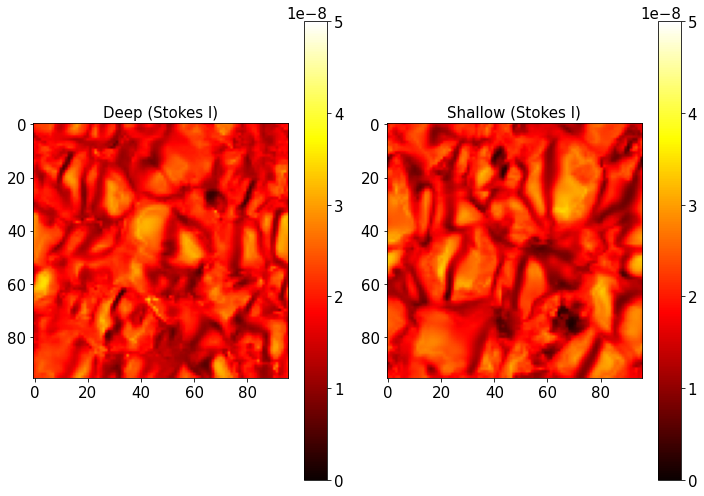

In [92]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('Deep (Stokes I)',size = 15)
plt.imshow(deep_I[lc,0],cmap='hot')
plt.clim(0,5e-8)
plt.colorbar()
plt.subplot(122)
plt.title('Shallow (Stokes I)',size = 15)
plt.imshow((shallow_I[lc,0]),cmap='hot')
plt.clim(0,5e-8)
plt.colorbar()
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig("/Users/kulkarniad/Desktop/deep_vs_shallow_I.png",bbox_inches = 'tight')

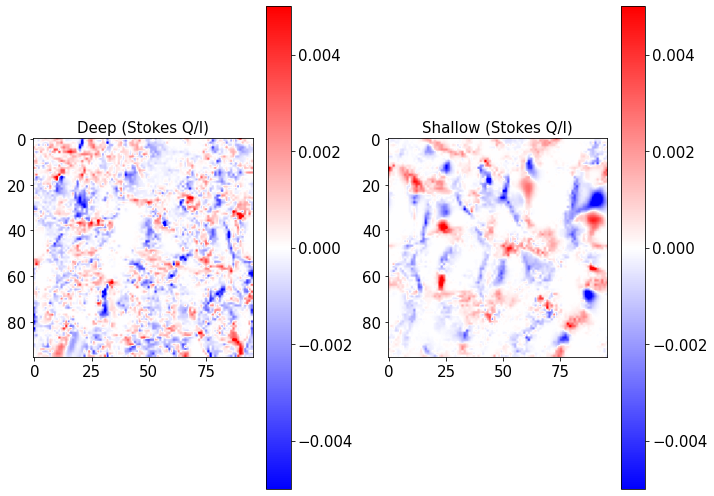

In [93]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('Deep (Stokes Q/I)',size = 15)
plt.imshow(deep_Q[lc,0]/deep_I[ni,0],cmap='bwr')
plt.clim(-0.005,0.005)
plt.colorbar()
plt.subplot(122)
plt.title('Shallow (Stokes Q/I)',size = 15)
plt.imshow(shallow_Q[lc,0]/shallow_I[ni,0],cmap='bwr')
plt.clim(-0.005,0.005)
plt.colorbar()
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
#plt.savefig("/Users/kulkarniad/Desktop/deep_vs_shallow_I.png",bbox_inches = 'tight')

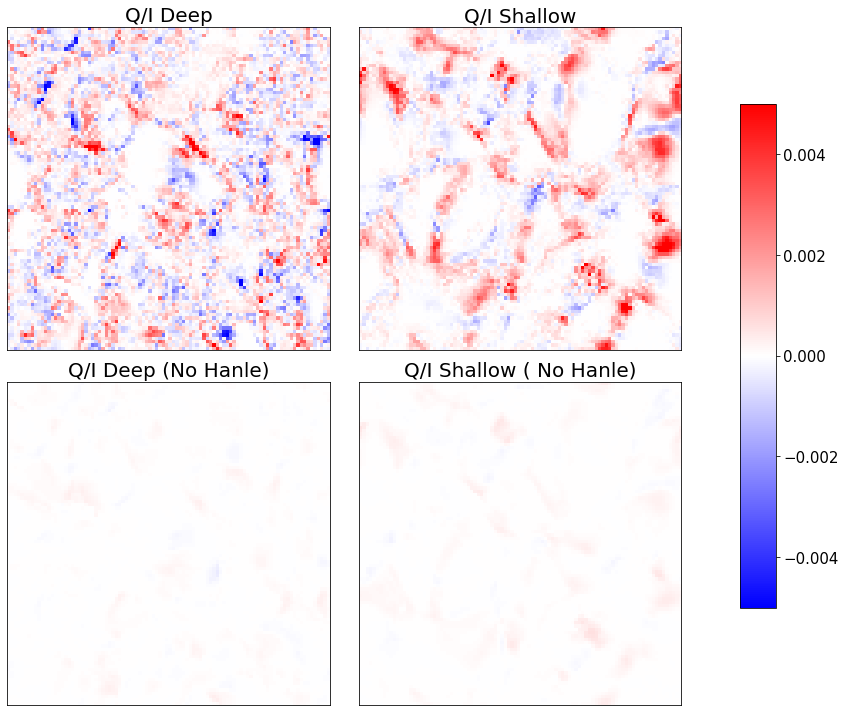

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))
allAx = axes.flat

im = allAx[0].imshow(deep_U[lc,0]/deep_I[ni,0],vmin = -0.005, vmax = 0.005,cmap = 'bwr')
allAx[0].set_title('Q/I Deep',fontsize = 20)

allAx[1].imshow(shallow_U[lc,0]/shallow_I[ni,0],vmin = -0.005, vmax = 0.005,cmap = 'bwr')
allAx[1].set_title('Q/I Shallow',fontsize = 20)

allAx[2].imshow(nohanle_deep_U[lc,0]/nohanle_deep_I[ni,0],vmin = -0.1, vmax = 0.1,cmap = 'bwr')
allAx[2].set_title('Q/I Deep (No Hanle)',fontsize = 20)


allAx[3].imshow(nohanle_shallow_U[lc,0]/nohanle_shallow_I[ni,0],vmin = -0.1, vmax = 0.1,cmap = 'bwr')
allAx[3].set_title('Q/I Shallow ( No Hanle)',fontsize = 20)

#remove ticks
for i in range(4):
    plt.setp(allAx[i].get_xticklabels(), visible=False)
    plt.setp(allAx[i].get_yticklabels(), visible=False)
    allAx[i].tick_params(axis='both', which='both', length=0)


fig.tight_layout()
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("/Users/kulkarniad/Desktop/deep_vs_shallow_Q.png",bbox_inches = 'tight')

NameError: name 'hanle_deep_Q' is not defined

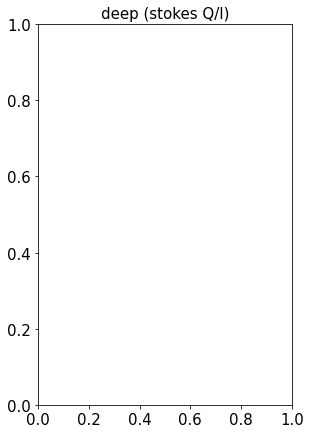

In [55]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('deep (stokes Q/I)',size = 15)
plt.imshow(hanle_deep_Q[lc,0],cmap='bwr')
#plt.clim(-0.1,0.1)
plt.colorbar()
plt.subplot(122)
plt.title('shallow (stokes Q/I)',size = 15)
plt.imshow(deep_Q[lc,0],cmap='bwr')
#plt.clim(-0.1,0.1)
plt.colorbar()
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"




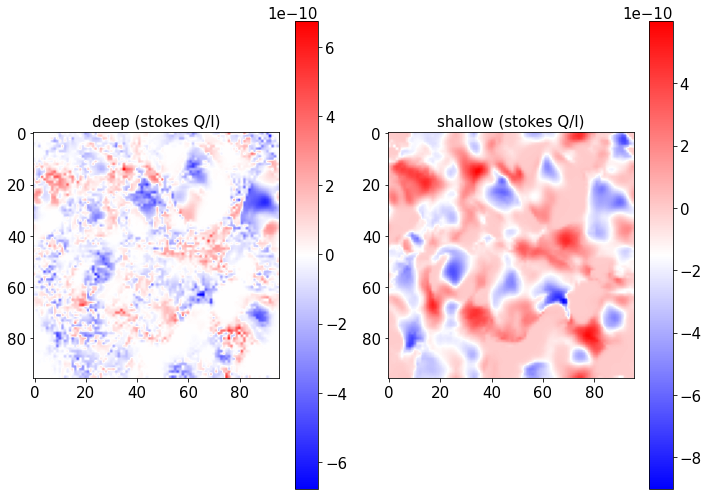

In [249]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('deep (stokes Q/I)',size = 15)
plt.imshow(hanle_shallow_Q[lc,0],cmap='bwr')
#plt.clim(-0.1,0.1)
plt.colorbar()
plt.subplot(122)
plt.title('shallow (stokes Q/I)',size = 15)
plt.imshow(shallow_Q[lc,0],cmap='bwr')
#plt.clim(-0.1,0.1)
plt.colorbar()
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"




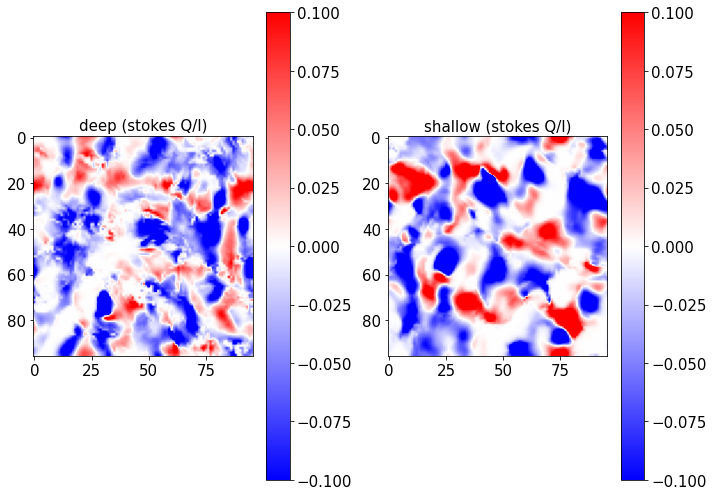

In [179]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title('deep (stokes Q/I)',size = 15)
plt.imshow(deep_Q[lc,0]/(deep_I[ni,0]),cmap='bwr')
plt.clim(-0.1,0.1)
plt.colorbar()
plt.subplot(122)
plt.title('shallow (stokes Q/I)',size = 15)
plt.imshow(shallow_Q[lc,0]/(shallow_I[ni,0]),cmap='bwr')
plt.clim(-0.1,0.1)
plt.colorbar()
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"




In [48]:
start = time.time()
src_fnc = Source_function('mur_100/')

i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('mur100_I.fits',overwrite=True)

i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('mur100_Q.fits',overwrite=True)

i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('mur100_U.fits',overwrite=True)

print(time.time() - start)

972.5249869823456


In [19]:
i = fits.open('mur100_I.fits')[0].data
q = fits.open('mur100_Q.fits')[0].data
u = fits.open('mur100_U.fits')[0].data


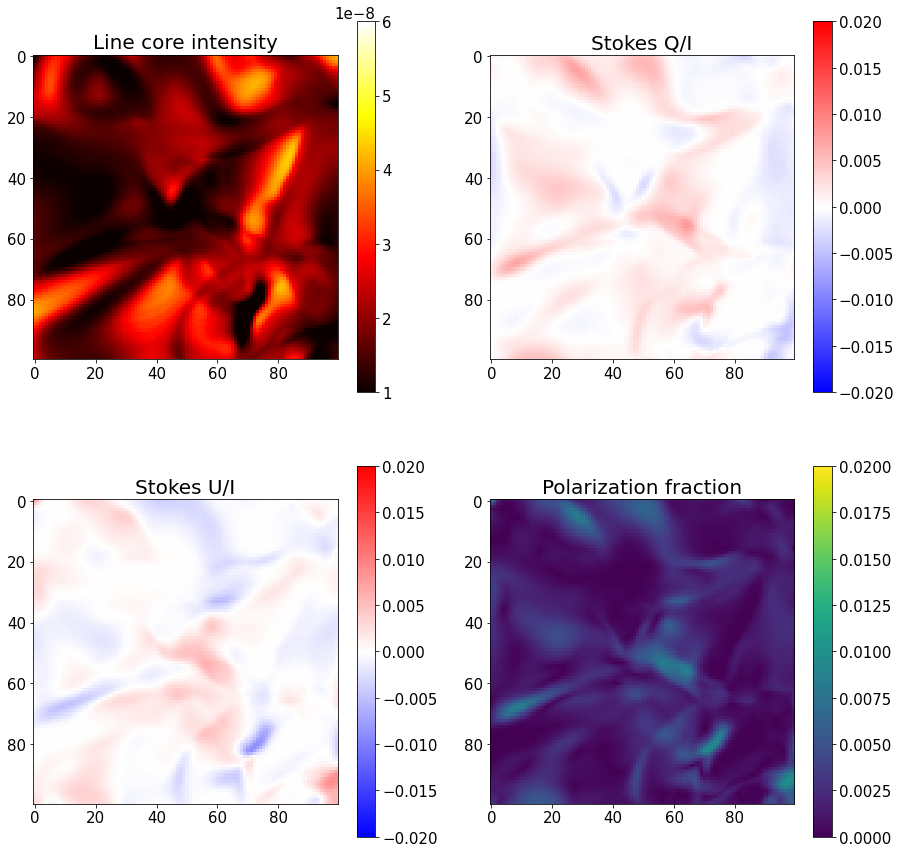

In [30]:
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(i[lc,0],cmap='hot')
plt.clim(1e-8,6e-8)
plt.title('Line core intensity',fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 

plt.subplot(222)
plt.title('Stokes Q/I',fontsize=20)
plt.imshow(q[lc,0]/i[ni,0],cmap='bwr')
plt.clim(-2e-2,2e-2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 

plt.subplot(223)
plt.title('Stokes U/I',fontsize=20)
plt.imshow(u[lc,0]/i[ni,0],cmap='bwr')
plt.clim(-2e-2,2e-2)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 

plt.subplot(224)
plt.title('Polarization fraction',fontsize=20)
plt.imshow(np.sqrt(q[lc,0]**2 + u[lc,0]**2)/i[ni,0])
plt.clim(0,0.02)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 

plt.savefig('/Users/kulkarniad/Desktop/mur100_pol.png')

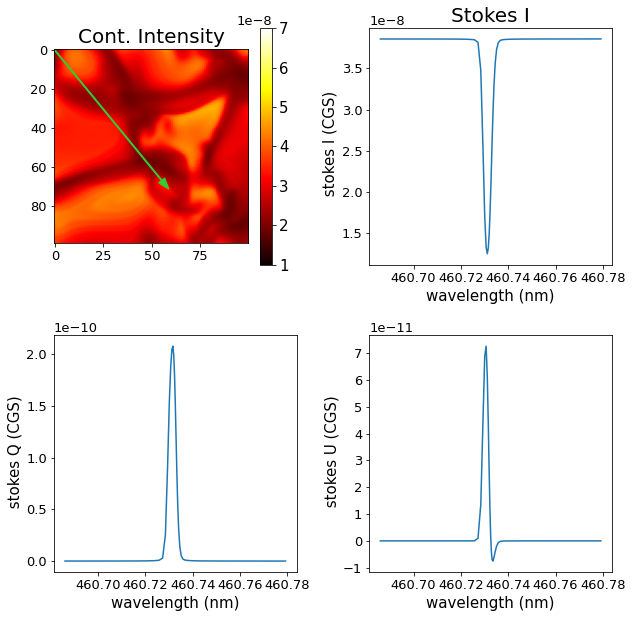

In [242]:
plt.figure(figsize=(10,10))

pi = 55
pj = 67

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.subplot(221)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.arrow(0, 0, pi, pj,width = 0.5,head_width = 4,color = 'limegreen',linestyle = '-')
plt.imshow(i[ni,0],cmap='hot')
plt.clim(1e-8,7e-8)
plt.title('Cont. Intensity',fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15) 

plt.subplot(222)
plt.title('Stokes I',fontsize=20)
plt.plot(wl[ni+7:nf-7],i[ni+7:nf-7,0,pi,pj])
plt.xlabel('wavelength (nm)',fontsize=15)
plt.ylabel(' stokes I (CGS)',fontsize=15)

plt.subplot(223)
plt.plot(wl[ni+7:nf-7],q[ni+7:nf-7,0,pi,pj])
plt.xlabel('wavelength (nm)',fontsize=15)
plt.ylabel(' stokes Q (CGS)',fontsize=15)


plt.subplot(224)
plt.plot(wl[ni+7:nf-7],u[ni+7:nf-7,0,pi,pj])
plt.xlabel('wavelength (nm)',fontsize=15)
plt.ylabel(' stokes U (CGS)',fontsize=15)


plt.savefig('/Users/kulkarniad/Desktop/mur100_pol.png')

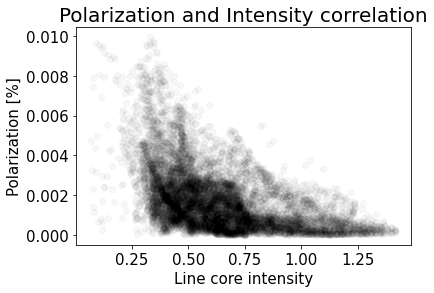

In [35]:
pol = np.sqrt(q[lc,0]**2 + u[lc,0]**2)
pol /= i[ni,0]

norm_I = i[lc,0] / np.mean(i[ni,0])

plt.scatter(norm_I,pol,alpha=0.03,color = 'black')
plt.title('Polarization and Intensity correlation',fontsize=20)
plt.xlabel('Line core intensity',fontsize=15)
plt.ylabel('Polarization [%]',fontsize=15)
plt.savefig('/Users/kulkarniad/Desktop/polscatter.png',bbox_inches = 'tight')
plt.show()


## Role of horizontal velocities

In [44]:
smallQ = fits.open('new_small_Q.fits')[0].data
smallU = fits.open('new_small_U.fits')[0].data
smallI = fits.open('new_small_I.fits')[0].data

novel_smallQ = fits.open('new_small_novel_Q.fits')[0].data
novel_smallU = fits.open('new_small_novel_U.fits')[0].data
novel_smallI = fits.open('new_small_novel_I.fits')[0].data

In [45]:
smallI.shape

(472, 64, 50, 50)

In [78]:
del im

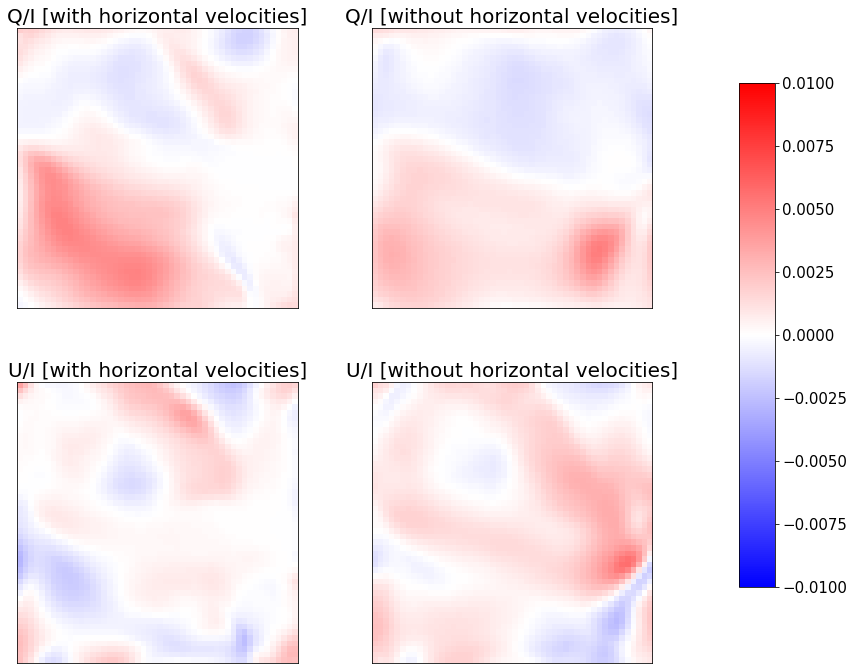

In [122]:

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))
allAx = axes.flat

allAx[0].imshow(smallQ[lc,0]/smallI[ni,0],vmin = -0.01, vmax = 0.01,cmap = 'bwr')
allAx[0].set_title('Q/I [with horizontal velocities]',fontsize = 20)

allAx[1].imshow(novel_smallQ[lc,0]/novel_smallI[ni,0],vmin = -0.01, vmax = 0.01,cmap = 'bwr')
allAx[1].set_title('Q/I [without horizontal velocities]',fontsize = 20)

allAx[2].imshow(smallU[lc,0]/smallI[ni,0],vmin = -0.01, vmax = 0.01,cmap = 'bwr')
allAx[2].set_title('U/I [with horizontal velocities]',fontsize = 20)

allAx[3].imshow(novel_smallU[lc,0]/novel_smallI[ni,0],vmin = -0.01, vmax = 0.01,cmap = 'bwr')
allAx[3].set_title('U/I [without horizontal velocities]',fontsize = 20)

#remove ticks
for i in range(4):
    plt.setp(allAx[i].get_xticklabels(), visible=False)
    plt.setp(allAx[i].get_yticklabels(), visible=False)
    allAx[i].tick_params(axis='both', which='both', length=0)


fig.tight_layout()
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("/Users/kulkarniad/Desktop/horizon_vel.png",bbox_inches = 'tight')

# Smoothened version of small atmosphere:

In [17]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/new_smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_small_I.fits',overwrite=True)

In [18]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/new_smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_small_Q.fits')

In [19]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/new_smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_small_U.fits')

# Smoothened by different amounts

In [15]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_0/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_0_small_I.fits',overwrite=True)

src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_0/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_0_small_Q.fits')

src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_0/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_0_small_U.fits')

In [17]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_001/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_001_small_I.fits',overwrite=True)

src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_001/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_001_small_Q.fits')

src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/mur_smooth_001/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_001_small_U.fits')

# Synthesize full reconstruction

In [30]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_I.fits',overwrite=True)

In [31]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_Q.fits',overwrite=True)

In [32]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/smooth_reconstruct/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('smooth_reconstruct_U.fits',overwrite=True)

# Synthesize more stuff

In [33]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetau/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetau_I.fits',overwrite=True)

In [34]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetau/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetau_Q.fits',overwrite=True)

In [35]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetau/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetau_U.fits',overwrite=True)

# Even more stuff:

In [36]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetemp/')
i_out = formal_3d(src_fnc.source_i(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetemp_I.fits',overwrite=True)

In [37]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetemp/')
i_out = formal_3d(src_fnc.source_q(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetemp_Q.fits',overwrite=True)

In [38]:
src_fnc = Source_function('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_truetemp/')
i_out = formal_3d(src_fnc.source_u(1.0,0.0),src_fnc.tau_cube)
hdu = fits.PrimaryHDU(i_out)
hdu.writeto('reconstruct_truetemp_U.fits',overwrite=True)

# Analyzing outputs

In [40]:
def compare(sim,recon,k_index):
    wl_flag = 0
    neg_flag = 0

    if sim.shape == (NLAMBDA,NZ,NY,NX):
        sim = sim[lc]  #look at line center wavelength
        recon = recon[lc] #look at line center wavelength

    if np.min(sim) <= 0.0:
        neg_flag = 1

    if neg_flag == 1:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.imshow(sim[k_index],cmap='bwr')
        up = np.max(np.abs(sim[k_index]))
        plt.clim(-up,up)
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(recon[k_index],cmap='bwr')
        plt.clim(-up,up)
        plt.colorbar()
        plt.show()

    if neg_flag == 0:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.imshow(sim[k_index],cmap='hot')
        up = np.max(sim[k_index])
        lo = np.min(sim[k_index])
        plt.clim(lo,up)
        plt.colorbar()

        plt.subplot(122)
        plt.imshow(recon[k_index],cmap='hot')
        plt.clim(lo,up)
        plt.colorbar()
        plt.show()


In [48]:
true_Q.shape

(472, 64, 50, 50)

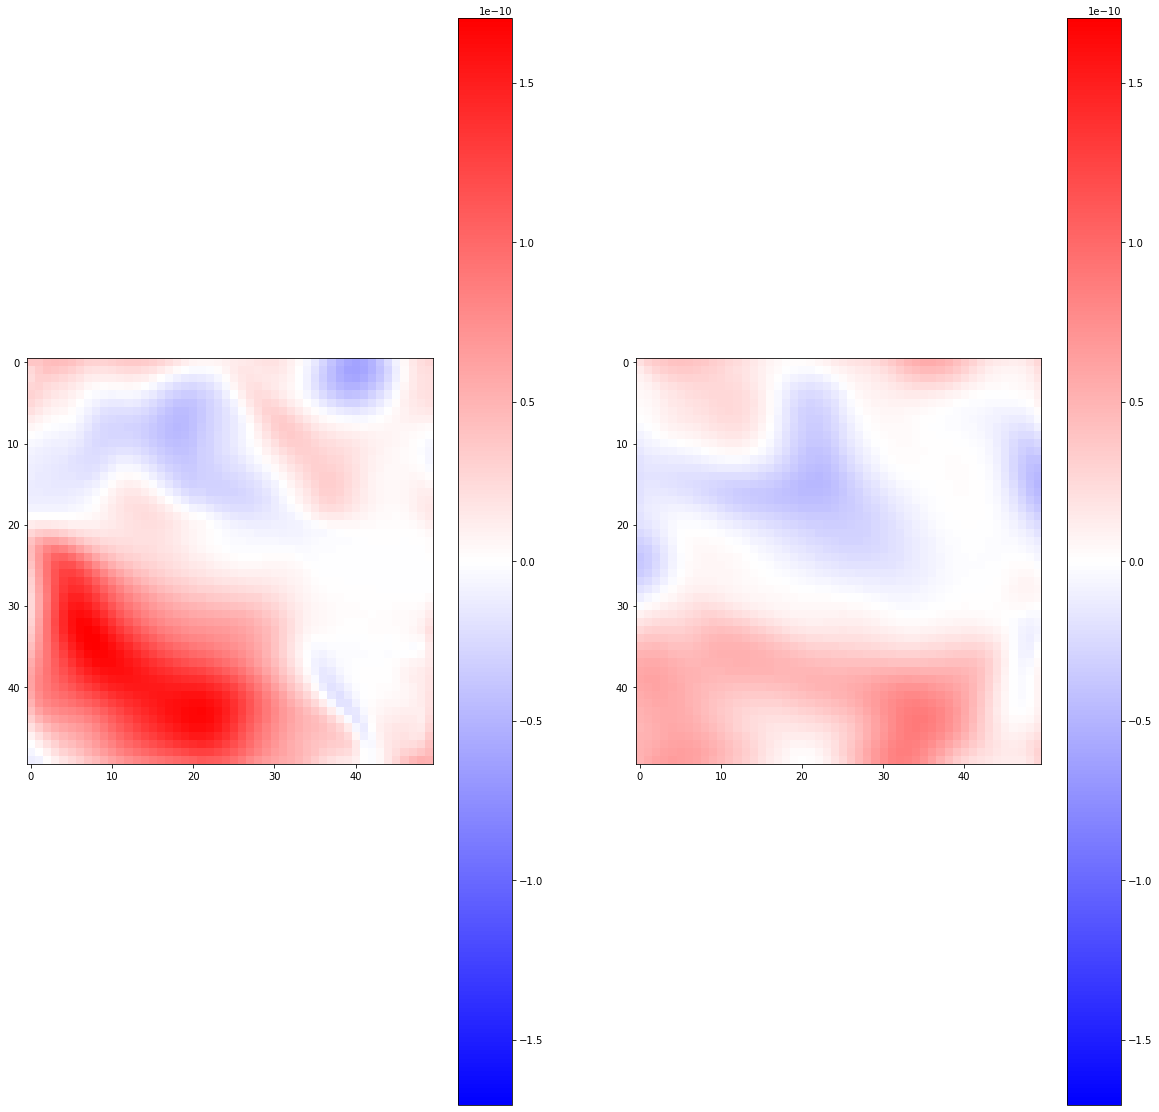

In [47]:
compare(true_Q,recons_Q,0)

# Observing with 0.76 m telescope

In [593]:
lc

33

In [600]:
from scipy.signal import convolve2d

In [601]:
lambda_0 = 4607e-10 # metres
D = 0.76 # Dunn solar telescope diameter
au = 1.496e11
dx_sim = 23*1e3 # 23 km pixels

In [602]:
theta_0 = 1.22 * lambda_0/D  # diffraction limit

pix_to_arcsec = dx_sim/au

x_width = pix_to_arcsec * NX
y_width = pix_to_arcsec * NY


In [603]:
r_airy = theta_0/pix_to_arcsec

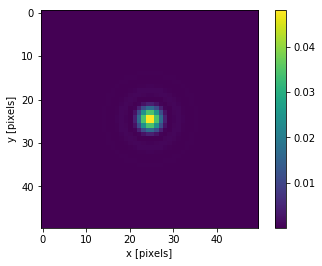

In [604]:
from astropy.convolution import AiryDisk2DKernel
airydisk_2D_kernel = AiryDisk2DKernel(r_airy,x_size = NX,y_size = NY)
plt.imshow(airydisk_2D_kernel)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

In [617]:
observed_I = convolve2d(true_I[0,0], airydisk_2D_kernel, mode='same',boundary='symm')
observed_Q = convolve2d(true_Q[lc,0], airydisk_2D_kernel, mode='same',boundary='symm')
observed_U = convolve2d(true_U[lc,0], airydisk_2D_kernel, mode='same',boundary='symm')

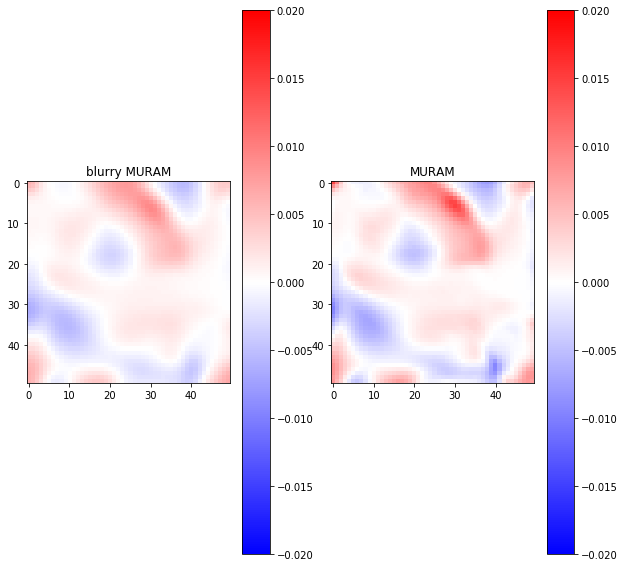

In [618]:
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.title('blurry MURAM')
plt.imshow(observed_U/observed_I,cmap='bwr')
plt.colorbar()
plt.clim(-0.02,0.02)

plt.subplot(122)
plt.title('MURAM')
plt.imshow(true_U[lc,0]/true_I[0,0],cmap='bwr')
plt.colorbar()
plt.clim(-0.02,0.02)

plt.show()
